In [0]:
from __future__ import absolute_import, division, print_function

#!pip install -q tensorflow==2.0.0-alpha0
!pip install tensorflow-gpu==2.0.0-beta1
!pip install pynrrd

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import random
import math
import pickle

from random import shuffle

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import scale

!pip install scikit-image
#from skimage.transform import resize
from numpy.random import choice
import matplotlib.pyplot as plt

import nrrd
import time

In [0]:
tf.test.is_gpu_available()

True

In [0]:
# Source : https://stackoverflow.com/questions/9770668/scramble-python-list

def scrambled(orig):
    dest = orig[:]
    random.shuffle(dest)
    return dest

In [0]:
len(os.listdir("final_vols/rescale_100_all/Test"))

72

## READ-IN FILENAMES

In [0]:
train_filenames = scrambled(os.listdir('final_vols/rescale_100_all/Train'))
#train_filenames.remove(".ipynb_checkpoints")

#val_filenames = scrambled(os.listdir('final_vols/rescale_100_reg1_all/Val'))

testval_filenames = scrambled(os.listdir('final_vols/rescale_100_all/Test'))

In [0]:
train_csv = pd.read_excel("excel_files/seattle.xlsx", index_col=None)
#val_csv = pd.read_excel("excel_files/Data_mask.val.new.xlsx", index_col=None)
testval_csv = pd.read_excel("excel_files/tum.xlsx", index_col=None)

In [0]:
# Create the initial split for test and val

# test_filenames = testval_filenames[:40]
# val_filenames = testval_filenames[40:]

In [0]:
# Save the initial split for test and val

# with open("test_filenames.txt", "wb") as fp:
#     pickle.dump(test_filenames, fp)

# with open("val_filenames.txt", "wb") as fp:
#     pickle.dump(val_filenames, fp)

In [0]:
test_filenames = []
val_filenames = []

with open("excel_files/test_filenames.txt", "rb") as fp:
    test_filenames = pickle.load(fp)
    
with open("excel_files/val_filenames.txt", "rb") as fp:
    val_filenames = pickle.load(fp)

In [0]:
len(val_filenames)

32

In [0]:
uncen = 0
for i in train_filenames:
    #print(j[:-4])
    i = i[:-4] +".nrrd"
    temp_sos = train_csv.loc[train_csv['Image'] == i]['Status OS'].values[0]
    if temp_sos == 1:
        uncen += 1
print(uncen)

42


In [0]:
# for index, i in enumerate(train_filenames):
#      print(i)
# len(train_filenames)

## READ-IN DATASET

In [0]:
# Create training data
train_data = []

for index, i in enumerate(train_filenames):
    if index % 10 == 0:
      print(index)
    tmp = "final_vols/rescale_100_all/Train/" + i
    npz = np.load(tmp)
    tmp_vol = npz['vol']
    tmp_os = npz['os']
    tmp_sos = npz['sos']
    #print(tmp_sos)
    tmp_age = npz['age']
    #tmp_nest = [tmp_vol, tmp_os, tmp_sos, tmp_age, i]
    tmp_row = np.squeeze(train_csv.loc[train_csv["Image"] == i[:-4] + ".nrrd"]).values[5:-1]
    tmp_nest = [tmp_vol, tmp_os, tmp_sos]
    print(tmp_row)
    tmp_nest.extend(tmp_row)
    train_data.append(tmp_nest)

In [0]:
val_data = []

for i in val_filenames:
    tmp = "final_vols/rescale_100_all/Test/" + i
    npz = np.load(tmp)
    tmp_vol = npz['vol']
    tmp_os = npz['os']
    tmp_sos = npz['sos']
    tmp_age = npz['age']
    #tmp_nest = [tmp_vol, tmp_os, tmp_sos, tmp_age, i]
    tmp_row = np.squeeze(testval_csv.loc[testval_csv["Image"] == i[:-4] + ".nrrd"]).values[5:-1]
    print(tmp_row)
    tmp_nest = [tmp_vol, tmp_os, tmp_sos]
    tmp_nest.extend(tmp_row)
    val_data.append(tmp_nest)

In [0]:
test_data = []

for i in test_filenames:
    tmp = "final_vols/rescale_100_all/Test/" + i
    npz = np.load(tmp)
    tmp_vol = npz['vol']
    tmp_os = npz['os']
    tmp_sos = npz['sos']
    tmp_age = npz['age']
    #tmp_nest = [tmp_vol, tmp_os, tmp_sos, tmp_age, i]
    tmp_row = np.squeeze(testval_csv.loc[testval_csv["Image"] == i[:-4] + ".nrrd"]).values[5:-1]
    print(tmp_row)
    tmp_nest = [tmp_vol, tmp_os, tmp_sos]
    tmp_nest.extend(tmp_row)
    test_data.append(tmp_nest)

## Convert to NumPy

In [0]:
# 3: means radiomics + age,grade (1028)
# 5 : means only radiomics (1026)

# import sklearn
# from sklearn.model_selection import train_test_split
# test1 , test2 = sklearn.model_selection.train_test_split(test_data, test_size = 0.5)
# val1 , val2 = sklearn.model_selection.train_test_split(val_data, test_size = 0.5)

In [0]:
# test_data = np.concatenate([test1,val1], axis = 0)
# val_data = np.concatenate([test2,val2], axis = 0)

In [0]:
# ra_tr = [i[3] for i in train_data]
# ra_vl = [i[3] for i in val_data]
# ra_ts = [i[3] for i in test_data]


In [0]:
# any(i in ra_vl for i in ra_tr)

In [0]:
counts = 0
for idx,sample in enumerate(val_data):
    if sample[2] == 0:
        counts += 1
print(counts)
        

23


In [0]:
len(val_data)

In [0]:
for i in [3,55,43,2, 32, 29, 14]:
    print(train_data[i][1:6])

In [0]:
#Convert to NumPy

x_train = np.stack(np.array(train_data)[:,0], axis = 0)
x_train_rad = np.stack(np.array(train_data)[:,3:], axis = 0)
y_train = np.stack(np.array(train_data)[:,1], axis = 0)

# CHANGE : <- no idea
x_val = np.stack(np.array(val_data)[:,0], axis = 0)
x_val_rad = np.stack(np.array(val_data)[:,3:], axis = 0)
y_val = np.stack(np.array(val_data)[:,1], axis = 0)

x_test = np.stack(np.array(test_data)[:,0], axis = 0)
x_test_rad = np.stack(np.array(test_data)[:,3:], axis = 0)
y_test = np.stack(np.array(test_data)[:,1], axis = 0)

In [0]:
val_data[1][3]

In [0]:
np.shape(x_test_rad)

In [0]:
np.shape(x_train_rad)

In [0]:
# del train_data
# del test_data

In [0]:
# for i in np.std(x_test_rad, axis = 0):
#     print(i)

In [0]:
from sklearn.preprocessing import StandardScaler
st_scale_tr = StandardScaler()
st_scale_tr.fit(x_train_rad)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
x_val_rad = st_scale_tr.transform(x_val_rad)
x_test_rad = st_scale_tr.transform(x_test_rad)

In [0]:
# x_train_rad = scale(x_train_rad)
# x_val_rad = scale(x_val_rad)
# x_test_rad = scale(x_test_rad)

In [0]:
# for i in np.mean(x_val_rad, axis = 0):
#     print(i)

In [0]:
x_val_rad.dtype

In [0]:
# np.isnan(x_train).any()

## PCA

In [0]:
# We've already created this in a upstairs

# x_train_rad = np.stack(np.array(train_data)[:,5:], axis = 0)
# st_scale_tr = StandardScaler()
x_train_rad = st_scale_tr.transform(x_train_rad)

In [0]:
np.std(x_train_rad, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [0]:
from sklearn.decomposition import PCA

pca = PCA(20)
pca.fit(x_train_rad)
#x_train_rad = pca.transform(x_train_rad)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
np.sum(pca.explained_variance_ratio_)

0.921051369189522

In [0]:
# Create training data
# 7: from the original excel file means only radiomics, no age,grade
train_data_r = []

for index, i in enumerate(train_filenames):
    if index % 10 == 0:
      print(index)
    tmp = "final_vols/rescale_100_all/Train/" + i
    npz = np.load(tmp)
    tmp_vol = npz['vol']
    tmp_os = npz['os']
    tmp_sos = npz['sos']
    #print(tmp_sos)
    tmp_age = npz['age']
    #tmp_nest = [tmp_vol, tmp_os, tmp_sos, tmp_age, i]
    tmp_row = np.squeeze(train_csv.loc[train_csv["Image"] == i[:-4] + ".nrrd"]).values[5:-1]
    tmp_row = st_scale_tr.transform(np.expand_dims(tmp_row, axis=0))
    print(np.shape(tmp_row))
    pca_tmp_row = pca.transform(tmp_row)
    print(np.shape(pca_tmp_row))
    tmp_nest = [tmp_vol, tmp_os, tmp_sos]
#     l_pca_tmp_row = list(pca_tmp_row)
#     print(np.shape(l_pca_tmp_row))
    tmp_nest.extend(np.squeeze(pca_tmp_row))
    print(np.shape(tmp_nest))
    train_data_r.append(tmp_nest)

In [0]:
for i in x_test_rad:
    print(np.sum(i))

In [0]:
np.shape(x_test_rad)

x_val_rad = pca.transform(x_val_rad)
x_test_rad = pca.transform(x_test_rad)

In [0]:
np.shape(x_test_rad)

In [0]:
for i in np.array(train_data_r):
    print(np.sum(i[3:]))

In [0]:
# np.shape(train_data_r[1])

In [0]:
# train_data_r[1].extend(list(train_data_r[1][3]))

In [0]:
del train_data

## Plot volumes

In [0]:
# ind = 18
# vols = x_train
# f,ax = plt.subplots(1,5, figsize = (25,25))
# sls = [20,40,50,70,90]
# for i,j in enumerate(sls):
#     ax[i].imshow(np.squeeze(vols[ind])[:,:,j])
# plt.show()

In [0]:
np.shape(train_data_r[1][1:])

## Store event times

In [0]:
def get_event_times(batch):
    event_times = []
    
    for ind, j in enumerate(batch):
        time = j[1]
        if j[2] == 1:
            event_times.append((ind,time))

    return event_times

In [0]:
# Store event times for validation data

val_event_times = []

for ind, j in enumerate(val_data):
    time = j[1]
    if j[2] == 1:
        val_event_times.append((ind,time))

In [0]:
# Store event times for test data

tst_event_times = []

for ind, j in enumerate(test_data):
    time = j[1]
    if j[2] == 1:
        tst_event_times.append((ind,time))

In [0]:
np.shape(train_data_r[1][2])

()

## Get Random Batch

In [0]:
def get_batch(batchnum, batchsize):
    
    #Changed everything to train_data_r
    #print("in")
    if batchnum == 0:
        #print("Batchnum 0")
        shuffle(train_data_r)
    
        num = (len(train_data_r) // batchsize) + 1
        lens = []


        for i in range(num):
            begin = 0 + (i * batchsize)
            end = begin + batchsize
            event_times = get_event_times(train_data_r[begin:end])
            lens.append(len(event_times))
        contains_no_zeros = np.all(lens)
    
        while not contains_no_zeros:
            shuffle(train_data_r)
            num = (len(train_data_r) // batchsize) + 1
            lens = []
            for i in range(num):
                begin = 0 + (i * batchsize)
                end = begin + batchsize
                event_times = get_event_times(train_data_r[begin:end])
                lens.append(len(event_times))
            contains_no_zeros = np.all(lens)
    
    #print("out")
    begin = 0 + (batchnum * batchsize)
    end = begin + batchsize
    
    begin = 0 + (batchnum * batchsize)
    end = begin + batchsize
    
    #Changed to train_data_r for PCA
    x_train = np.stack(np.array(train_data_r)[begin:end,0], axis = 0)
    x_train_rad = np.stack(np.array(train_data_r)[begin:end,3:], axis = 0)
    y_train = np.stack(np.array(train_data_r)[begin:end,1], axis = 0)
    
    #Commented out for PCA
#   x_train_rad = st_scale_tr.transform(x_train_rad)
    
    #Changed to train_data_r for PCA
    event_times = get_event_times(train_data_r[begin:end])
    batch = train_data_r[begin:end]
    
    #print(begin,end)
    return x_train, x_train_rad, y_train, event_times, batch

## Custom Loss

In [0]:
#Negative partial log-likelihood

#TODO : Change parameter naming.
#TODO : Refactor code and make it more concise

def custom_loss(y_true, y_pred, batchnum, batch_event_times, batch):
  
  val_loss = 0
  loss = 0
  
  # TODO : Don't need the loss for val and test
  
  if batchnum == 9999 :
    num_events = len(val_event_times)
    for t in val_event_times:
      ind = t[0]
      point_loss = y_pred[ind]
      denom = 0
      
      for index, datapoint in enumerate(val_data):
        if datapoint[1] >= t[1]:
          denom = denom + tf.math.exp(y_pred[index])
     
      denom = tf.math.negative(tf.math.log(denom))
      point_loss = point_loss + denom
      val_loss = val_loss + point_loss    
    return tf.math.negative(val_loss/num_events)
  
  if batchnum == 8888 :
    num_events = len(tst_event_times)
    for t in tst_event_times:
      ind = t[0]
      point_loss = y_pred[ind]
      denom = 0
      
      for index, datapoint in enumerate(test_data):
        if datapoint[1] >= t[1]:
          denom = denom + tf.math.exp(y_pred[index])
     
      denom = tf.math.negative(tf.math.log(denom))
      point_loss = point_loss + denom
      tst_loss = tst_loss + point_loss    
    return tf.math.negative(tst_loss/num_events)
  
  else:    
  #  print(y_pred)
  #  print("Length of y_true is {} and length of y_pred is {}".format(np.shape(y_true), np.shape(y_pred)))
    # Only iterate over samples whose Status is 1
    
    num_events = len(batch_event_times)
    #print(batch_event_times)
    for t in batch_event_times:
      #print(num_events)
      ind = t[0]
      point_loss = y_pred[ind]
   #   print("initial point loss is {}".format(point_loss))
      denom = 0

      for index, datapoint in enumerate(batch):
       #Check whether sample is in the risk set
         if datapoint[1] >= t[1]:
   #       print("ypred is {}".format(y_pred[index]))
   #       print("exp is {}".format(tf.math.exp(y_pred[index])))
           denom = denom + tf.math.exp(y_pred[index])
   #       print("first denom is {}".format(denom))

      denom = tf.math.negative(tf.math.log(denom))
   #   print("second denom is {}".format(denom))
      point_loss = point_loss + denom
      loss = loss + point_loss
    #  print("point loss is {}, denom is {}".format(point_loss, denom))
   # print("loss is {}".format(loss))
    fin = tf.math.negative(loss/num_events)
    #print(fin)
    return fin

## Compute C-Index

In [0]:
def compute_cindex(pred_risk, batchnum, batch):
  
  #TODO : Fix double-counting
  #TODO : Refactor code and make it more concise
  
  permissible = 0
  concordant = 0
  total = 0
  
  #TODO : The val_index is suspiciously high. Unit test the block below.
  
  if batchnum == 9999:
    
    for i, sample_i in enumerate(val_data):   
      for j, sample_j in enumerate(val_data):
        
        total += 1
        
        if ((sample_i[1] < sample_j[1]) and (sample_i[2] == 0)) or\
        ((sample_i[1] > sample_j[1]) and (sample_j[2] == 0)) or\
        (sample_i[1] == sample_j[1]):
          continue


        permissible = permissible + 1

        if ((sample_i[1] < sample_j[1]) and (pred_risk[i] > pred_risk[j])) or ((sample_i[1] > sample_j[1]) and (pred_risk[i] < pred_risk[j])):
          concordant = concordant + 1
  #        print("Concordant is {}".format(concordant))

#  print("Permissible is {} and Concordant is {}".format(permissible,concordant))
#    print("Proportion accepted (val) is {}".format(permissible/total))
    return concordant/permissible

  if batchnum == 8888:
    
    for i, sample_i in enumerate(test_data):   
      for j, sample_j in enumerate(test_data):
        
        total += 1
        
        if ((sample_i[1] < sample_j[1]) and (sample_i[2] == 0)) or\
        ((sample_i[1] > sample_j[1]) and (sample_j[2] == 0)) or\
        (sample_i[1] == sample_j[1]):
          continue


        permissible = permissible + 1

        if ((sample_i[1] < sample_j[1]) and (pred_risk[i] > pred_risk[j])) or ((sample_i[1] > sample_j[1]) and (pred_risk[i] < pred_risk[j])):
          concordant = concordant + 1
  #        print("Concordant is {}".format(concordant))

#  print("Permissible is {} and Concordant is {}".format(permissible,concordant))
#    print("Proportion accepted (test) is {}".format(permissible/total))
    return concordant/permissible

  else:
  
    for i, sample_i in enumerate(batch):   
      for j, sample_j in enumerate(batch):
        
        total += 1
        
        if ((sample_i[1] < sample_j[1]) and (sample_i[2] == 0)) or\
        ((sample_i[1] > sample_j[1]) and (sample_j[2] == 0)) or\
        (sample_i[1] == sample_j[1]):
          continue


        permissible = permissible + 1

        if ((sample_i[1] < sample_j[1]) and (pred_risk[i] > pred_risk[j])) or ((sample_i[1] > sample_j[1]) and (pred_risk[i] < pred_risk[j])):
          concordant = concordant + 1
  #        print("Concordant is {}".format(concordant))

  #  print("Permissible is {} and Concordant is {}".format(permissible,concordant))
  #  print("Proportion accepted (train) is {}".format(permissible/total))
    if permissible == 0:
        print("permissible is zero")
        return 0.5
    return concordant/permissible

In [0]:
# Test another c-index function
# Source : https://codereview.stackexchange.com/questions/202140/concordance-index-calculation

import pandas as pd

def c_index1(y_pred, events, times):
    df = pd.DataFrame(data={'proba':y_pred, 'event':events, 'time':times})
    n_total_correct = 0
    n_total_comparable = 0
    
    df = df.sort_values(by=['time'])
    for i, row in df.iterrows():
        if row['event'] == 1:
            comparable_rows = df[(df['event'] == 0) & (df['time'] > row['time'])]
            n_correct_rows = len(comparable_rows[comparable_rows['proba'] < row['proba']])
            n_total_correct += n_correct_rows
            n_total_comparable += len(comparable_rows)
    
    #print("total comp is" + str(n_total_comparable))
    
    return n_total_correct / n_total_comparable if n_total_comparable else None

In [0]:
def get_cust_inputs(ypred, batch):
  events = np.array([i[2] for i in batch])
  #print(events)
  times = np.array([i[1] for i in batch])
  
  return ypred, events, times

## Build and Train

In [0]:
# Model to use for PCA features

reg = 0.1
act = "selu"
input_a = keras.Input(shape = (100,100,100, 1))
#CHANGE to 1028
input_b = keras.Input(shape = (20,))

# Conv branch

x = layers.Conv3D(32, kernel_size = (3, 3, 3), activation=act,\
                  kernel_regularizer = keras.regularizers.l2(0.1))(input_a)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D((2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size = (3, 3, 3), activation=act,\
                  kernel_regularizer = keras.regularizers.l2(0.1))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(32, kernel_size = (3, 3, 3), activation=act, \
                  kernel_regularizer = keras.regularizers.l2(0.1)) (x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D((2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size = (3, 3, 3), activation=act,\
                  kernel_regularizer = keras.regularizers.l2(0.1))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D((2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size = (3, 3, 3), activation=act,\
                  kernel_regularizer = keras.regularizers.l2(0.1))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling3D((2, 2, 2))(x)

x = layers.Flatten()(x)

# # Radiomics branch

r = layers.Dense(30, activation = act, \
                  kernel_regularizer = keras.regularizers.l2(0.1)) (input_b)
# r = layers.Dense(20, activation = act, \
#                  kernel_regularizer = keras.regularizers.l2(0.1)) (r)

xr = layers.Concatenate()([r,x])

# CHANGE BACK TO 20
xr = layers.Dense(15, activation = act, \
                  kernel_regularizer = keras.regularizers.l2(0.1))(xr)

xr = layers.Dense(10, activation = act, \
                  kernel_regularizer = keras.regularizers.l2(0.1))(xr)
# Try concatenating PCA here
output = layers.Dense(1, \
                  kernel_regularizer = keras.regularizers.l2(0.1))(xr)

model1x = keras.Model(inputs=[input_a, input_b], outputs = [output])

In [0]:
#model1x.save("doctry/initmodel.h5")

In [0]:
model1x = keras.models.load_model("doctry/initmodel.h5")

W1007 08:23:10.091157 140313078347584 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [0]:
model1x.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 10 0                                            
__________________________________________________________________________________________________
conv3d_5 (Conv3D)               (None, 98, 98, 98, 3 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 98, 98, 98, 3 128         conv3d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_4 (MaxPooling3D)  (None, 49, 49, 49, 3 0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [0]:
# model1s.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.0005),
#               loss='mse')

In [0]:
#Training


optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
num_epochs = 100
batch_size = 10
# CHANGE
num_batches = (len(train_data_r) // batch_size) + 1
model = model1x

current_epoch = 0
current_batch = 0

epoch_trn_losses = []
epoch_val_losses = []

epoch_trn_cindices = []
epoch_val_cindices = []

best = 0

for i in range(num_epochs):
  current_epoch = i
  
  epoch_trn_loss = 0
  epoch_val_loss = 0
  
  epoch_trn_cindex = 0
  epoch_val_cindex = 0
  
#   if current_epoch == 0:
#     model1s.save("first_model.h5")
#  print(i)
#CHANGE
#  for j in range(len(data)):
  for j in range(num_batches):
    current_batch = j
    #print(j)
    
 #   print(j)
    with tf.GradientTape() as tape:
  #    xtrain = np.array([k[0] for k in data[j]])
  #    print(np.shape(xtrain))
  #    ytrain = np.array([k[1] for k in data[j]])
  #    preds = np.squeeze(model(xtrain))
      
      # Forward pass on batch
    
      x_train, x_train_rad, y_train, batch_event_times, batch = get_batch(current_batch, batch_size)
      x_train_rad = tf.convert_to_tensor(x_train_rad, dtype=tf.float32)
      #Change type
      #print(x_train_rad.dtype)
      preds = model([x_train, x_train_rad])
      current_loss = custom_loss(y_train, preds, j, batch_event_times, batch)
      #print("Epoch is {} , batch is {}, (train) loss is {}".format(i,j,current_loss))
      epoch_trn_loss = epoch_trn_loss + current_loss
    
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    trn_cindex = compute_cindex(preds, j, batch)  
    #preds, events1, times1 = get_cust_inputs(preds,batch)
    #events = np.expand_dims(events, axis = 1)
    #times = np.expand_dims(times, axis = 1)
    #print(np.shape(preds))
    #print(np.shape(events))
    #print(np.shape(times))
    #preds = np.squeeze(preds)
    #print(np.shape(preds))
#     print(type(preds.numpy()))
#     print(type(events1))
#     print(type(times1))
    #trn_cindex = c_index1(np.squeeze(preds), np.array(events1), np.array(times1))
    epoch_trn_cindex = epoch_trn_cindex + trn_cindex
    
    
    val_preds = model.predict([x_val,x_val_rad], batch_size = 9)
    val_loss = custom_loss(y_val, val_preds, 9999, None, None)
    
    epoch_val_loss = epoch_val_loss + val_loss
  # TODO : Mystery  
  #  validation_losses.append(val_loss)
  
    val_cindex = compute_cindex(val_preds, 9999, None)    
    epoch_val_cindex = epoch_val_cindex + val_cindex
    
    #print("Epoch is {} , batch is {}, (val) loss is {}".format(i,j,val_loss))

    #print("Epoch is {} , batch is {}, (train) cindex is {}".format(i,j,trn_cindex))
    #print("Epoch is {} , batch is {}, (val) cindex is {}".format(i,j, val_cindex))
    
    #test_preds = model(x_test)
    #test_cindex = compute_cindex(test_preds, 8888, None)
    
 #   print("Epoch is {} , batch is {}, (test) cindex is {}".format(i,j,test_cindex))


  avg_trn = epoch_trn_loss/num_batches
  epoch_trn_losses.append(avg_trn)
  
  avg_val = epoch_val_loss/num_batches
  epoch_val_losses.append(avg_val)
    
  avg_trn_cind = epoch_trn_cindex/num_batches
  epoch_trn_cindices.append(avg_trn_cind)
  
  avg_val_cind = epoch_val_cindex/num_batches
  epoch_val_cindices.append(avg_val_cind)
  
  print("Average (train) loss of epoch {} is {}".format(i, avg_trn))
  print("Average (val) loss of epoch {} is {}".format(i, avg_val))
  
  print("Average (train) cindex of epoch {} is {}".format(i, avg_trn_cind))
  print("Average (val) cindex of epoch {} is {}".format(i, avg_val_cind))
  
  
  
  if avg_val_cind > best:
        print(str(avg_val_cind) + " is better than " + str(best))
        print("val cindex is " + str(val_cindex))
        best = avg_val_cind
        best_m = keras.models.clone_model(model)
        best_m.set_weights(model.get_weights())
  
  #Early stopping
  if (epoch_val_cindices[i] < epoch_val_cindices[i-1]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-2]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-3]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-4]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-5]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-6]) and \
    (epoch_val_cindices[i] < epoch_val_cindices[i-7]):
    
    print("best is " + str(best))
    #model.save("saved/task5/1x_0.1_selu_5e4_5/best_model.h5")
#     best_m.save("blah/best_model.h5")
    
#     with open("saved/task5/1x_0.1_selu_5e4_5/trn_losses.txt", "wb") as f:
#       pickle.dump(epoch_trn_losses, f)
    
#     with open("saved/task5/1x_0.1_selu_5e4_5/val_losses.txt", "wb") as f:
#       pickle.dump(epoch_val_losses, f)
      
#     with open("saved/task5/1x_0.1_selu_5e4_5/trn_cindices.txt", "wb") as f:
#       pickle.dump(epoch_trn_cindices, f)
      
#     with open("saved/task5/1x_0.1_selu_5e4_5/val_cindices.txt", "wb") as f:
#       pickle.dump(epoch_val_cindices, f)
     
    break

Average (train) loss of epoch 0 is [2.3287468]
Average (val) loss of epoch 0 is [6.440205]
Average (train) cindex of epoch 0 is 0.5151910346923134
Average (val) cindex of epoch 0 is 0.5489795918367346
0.5489795918367346 is better than 0
val cindex is 0.5314285714285715
Average (train) loss of epoch 1 is [2.1403296]
Average (val) loss of epoch 1 is [2.9287417]
Average (train) cindex of epoch 1 is 0.5968400483683255
Average (val) cindex of epoch 1 is 0.6620408163265307
0.6620408163265307 is better than 0.5489795918367346
val cindex is 0.6114285714285714
Average (train) loss of epoch 2 is [2.067106]
Average (val) loss of epoch 2 is [3.867876]
Average (train) cindex of epoch 2 is 0.5656125103330073
Average (val) cindex of epoch 2 is 0.46448979591836725
permissible is zero
Average (train) loss of epoch 3 is [1.4513348]
Average (val) loss of epoch 3 is [2.9161084]
Average (train) cindex of epoch 3 is 0.7302954072875835
Average (val) cindex of epoch 3 is 0.6310204081632653
Average (train) los

In [0]:
tpreds = best_m.predict([x_val,x_val_rad], batch_size = 5)
compute_cindex(tpreds, 9999, None)

0.6114285714285714

In [0]:
tpreds = best_m.predict([x_test,x_test_rad], batch_size = 5)
compute_cindex(tpreds, 8888, None)

0.5885416666666666

In [0]:
del best_m
del model1x
del model

In [0]:
tpreds = best_model.predict(x_test, batch_size = 5)
compute_cindex(tpreds, 8888, None)

In [0]:
tpreds = model.predict([x_test,x_test_rad], batch_size = 5)
compute_cindex(tpreds, 8888, None)

In [0]:
tpreds = model1x.predict([x_val,x_val_rad], batch_size = 5)
compute_cindex(tpreds, 9999, None)

In [0]:
tevents = [i[2] for i in test_data]
ttimes = [i[1] for i in test_data]
c_index1(np.squeeze(tpreds), np.array(tevents), np.array(ttimes))

In [0]:
np.shape(tpreds)

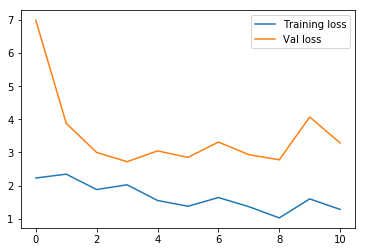

In [0]:
plt.plot(epoch_trn_losses, label="Training loss")
plt.plot(epoch_val_losses, label="Val loss")
plt.legend(loc="upper right")

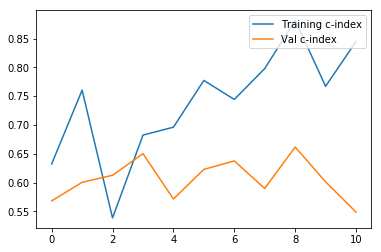

In [0]:
plt.plot(epoch_trn_cindices, label="Training c-index")
plt.plot(epoch_val_cindices, label="Val c-index")
plt.legend(loc="upper right")